In [2]:
%matplotlib inline
%load_ext line_profiler

%load_ext autoreload
%autoreload 2

import logging
logging.basicConfig(level=logging.INFO)

import os
import imageio

import numpy as np
import tqdm
import skimage
from skimage import data_dir, transform
from skimage.io import imread, imsave
import matplotlib.pyplot as plt

import xanespy as xp
# from find_opt_angle import find_optimal_180_angle
from find_offsets import image_corrections, logpolar_fancy, transform_image

phantom = imread(os.path.join(data_dir, "phantom.png"), as_grey=True)

# Prepare Transformed Data

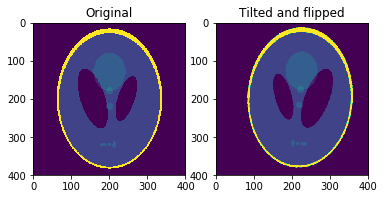

In [2]:
# Prepare transformed data
angle = -3
# angle = 0
translation = (20, 3)
# translation = (0, 0)

_angle = -np.radians(angle)

center = np.array((phantom.shape[1] / 2, phantom.shape[0] / 2))

tr0 = xp.xanes_math.transformation_matrices(translations=np.array([center]), rotations=np.array([_angle]))[0]
tr1 = xp.xanes_math.transformation_matrices(translations=np.array([-center]))[0]
tr2 = xp.xanes_math.transformation_matrices(translations=np.array([translation]))[0]

# print(help(transform))
tr = transform.FundamentalMatrixTransform(matrix=tr0 @ tr1 @ tr2)
phantom2 = transform.warp(phantom, tr)
phantom2 = np.flip(phantom2, axis=-1)

fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(phantom)
ax0.set_title("Original")
ax1.imshow(phantom2)
ax1.set_title("Tilted and flipped")

# Save images to disk
imsave('phantom-original.tiff', phantom.astype(np.float32))
imsave('phantom-tilted.tiff', phantom2.astype(np.float32))

# Evaluate the Alignment with Phantom

In [3]:
%time image_corrections('phantom-original.tiff', 'phantom-tilted.tiff', passes=20)

100%|██████████| 20/20 [00:02<00:00,  9.33it/s]

CPU times: user 3.95 s, sys: 149 ms, total: 4.1 s
Wall time: 2.15 s


(-3.0600000000000018, (20.0, 4.0))

In [4]:
%lprun -f transform_image image_corrections('phantom-original.tiff', 'phantom-tilted.tiff', passes=20)

100%|██████████| 20/20 [00:01<00:00, 13.85it/s]


In [6]:
rot, trans = image_corrections('phantom-original.tiff', 'phantom-tilted.tiff', passes=20)

print("Rot: {:.2f}°  Trans: {}".format(rot, trans))
deltaR = rot - angle
print("ΔR: {:.2f}° ({:.2f}%)".format(deltaR, deltaR / angle * 100))
deltaX = trans[0] - translation[0]
print("ΔX: {:.2f} ({:.2f}%)".format(deltaX, deltaX / translation[0] * 100))
deltaY = trans[1] - translation[1]
print("ΔY: {:.2f} ({:.2f}%)".format(deltaY, deltaY / translation[1] * 100))

100%|██████████| 20/20 [00:01<00:00, 11.68it/s]

Rot: -3.06°  Trans: (20.0, 3.0)
ΔR: -0.06° (2.00%)
ΔX: 0.00 (0.00%)
ΔY: 0.00 (0.00%)


# Evaluate the Efficacy Over Multiple Passes

/home/mwolf/miniconda3/envs/xanespy/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in double_scalars
/home/mwolf/miniconda3/envs/xanespy/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in double_scalars
/home/mwolf/miniconda3/envs/xanespy/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in double_scalars
/home/mwolf/miniconda3/envs/xanespy/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in double_scalars
/home/mwolf/miniconda3/envs/xanespy/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in double_scalars
/home/mwolf/miniconda3/envs/xanespy/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in double_scalars
/home/mwolf/miniconda3/envs/xanespy/lib/python3.5/site-packages/ipykernel/__main__.py:10: Runt

(0, 100)

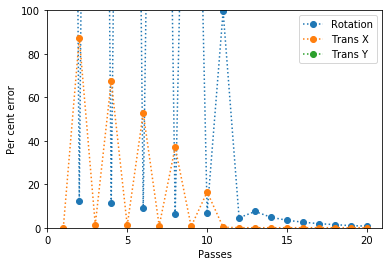

In [29]:
N = 20
passes = np.arange(0, N)

errors = np.empty(shape=(3, len(passes)), dtype=float)

for pss in passes:
    rot, trans = image_corrections('phantom-original.tiff', 'phantom-tilted.tiff', passes=pss+1)
    errors[0,pss] = (rot - angle) / angle * 100
    errors[1,pss] = (trans[0] - translation[0]) / translation[0] * 100
    errors[2,pss] = (trans[1] - translation[1]) / translation[1] * 100
    
plt.plot(passes+1, np.abs(errors[0]), marker='o', linestyle=":")
plt.plot(passes+1, np.abs(errors[1]), marker='o', linestyle=":")
plt.plot(passes+1, np.abs(errors[2]), marker='o', linestyle=":")
plt.legend(['Rotation', 'Trans X', "Trans Y"])
plt.gca().xaxis.set_ticks(np.arange(0, N+1, step=5))
plt.xlabel("Passes")
plt.ylabel("Per cent error")
plt.ylim(0, 100)

# Behavior of Log-Polar Transform

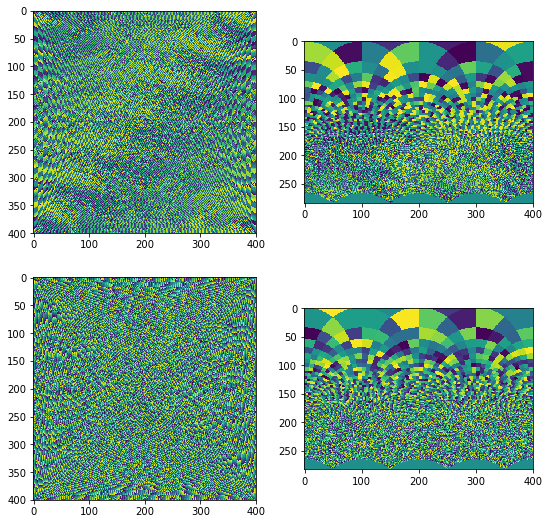

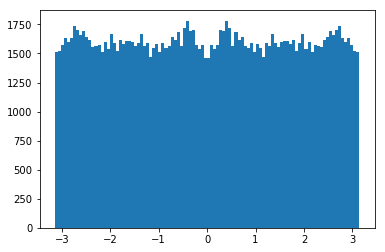

In [85]:
center = np.array(phantom.shape) / 2
# center = (0, 0)

phantom_ft = np.fft.fft2(phantom)
phantom2_ft = np.fft.fft2(phantom2)

phantom_lp = logpolar_fancy(phantom_ft, i_0=center[0], j_0=center[1])
phantom2_lp = logpolar_fancy(phantom2_ft, i_0=center[0], j_0=center[1])

fig, ax = plt.subplots(2, 2, figsize=(9,9))
(ax0, ax1), (ax2, ax3) = ax

comp = np.angle

vrange = (None, None) # 0, 2 * np.pi)
ax0.imshow(comp(phantom_ft), vmin=vrange[0], vmax=vrange[1])
ax1.imshow(comp(phantom_lp), vmin=vrange[0], vmax=vrange[1])

# vrange = (0, 100)
ax2.imshow(comp(phantom2_ft), vmin=vrange[0], vmax=vrange[1])
ax3.imshow(comp(phantom2_lp), vmin=vrange[0], vmax=vrange[1])

plt.figure()
plt.hist(comp(phantom_ft).flatten(), bins=100);


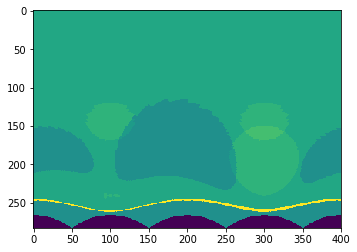

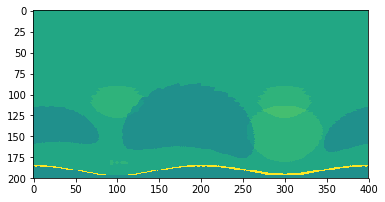

In [4]:
# Add 1 to phantom to be able to see cropping
phantom_high = phantom + 1
lp_phantom = logpolar_fancy(phantom_high)
plt.imshow(lp_phantom, vmin=0)

# Now try it with cropping
lp_phantom = logpolar_fancy(phantom_high, crop=True)
plt.figure()
plt.imshow(lp_phantom, vmin=0)

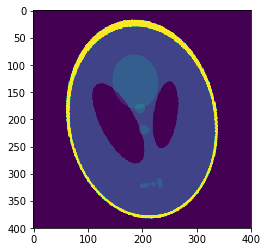

In [67]:
phantom_ = transform_image(phantom, rotation=10)
plt.imshow(phantom_)

# Cropping for Intermediate Transforms

35 365 35 365
0 395 0 390
30 360 15 345


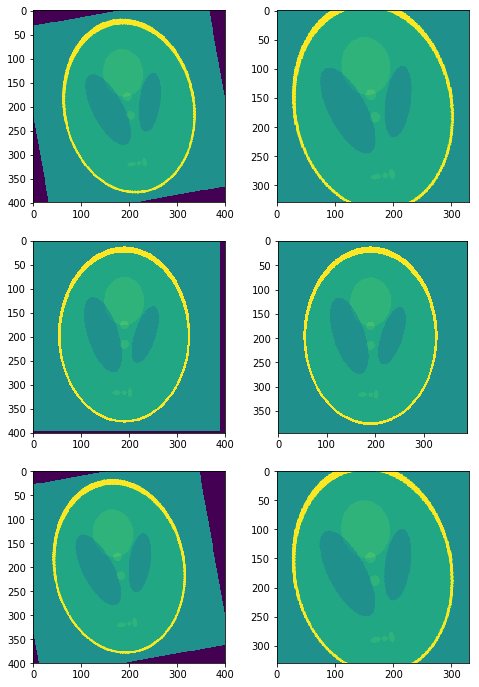

In [29]:
# Verify that none of these images have zero borders
fig, axs = plt.subplots(3, 2, figsize=(8, 12))
phantom_high = phantom + 1

# rotation only
rot_out = transform_image(phantom_high, rotation=10, crop=False)
rot_out_c = transform_image(phantom_high, rotation=10, crop=True)
ax0, ax1 = axs[0]
ax0.imshow(rot_out, vmin=0)
ax1.imshow(rot_out_c, vmin=0)

# Translation only
ax0, ax1 = axs[1]
out = transform_image(phantom_high, translation=(5, 10), crop=False)
ax0.imshow(out, vmin=0)
out = transform_image(phantom_high, translation=(5, 10), crop=True)
ax1.imshow(out, vmin=0)

# Translation and rotation
ax0, ax1 = axs[2]
out = transform_image(phantom_high, rotation=10, translation=(5, 20), crop=False)
ax0.imshow(out, vmin=0)
out = transform_image(phantom_high, rotation=10, translation=(5, 20), crop=True)
ax1.imshow(out, vmin=0)



# Test with Real Pin Data

  0%|          | 0/15 [00:00<?, ?it/s]DEBUG:find_offsets:Using image center (600v, 960h)
DEBUG:find_offsets:Using image center (600v, 960h)
DEBUG:find_offsets:Pass 0: 0.0000, [ 0.  -2.5]
  7%|▋         | 1/15 [00:01<00:20,  1.50s/it]DEBUG:find_offsets:Using image center (600v, 960h)
DEBUG:find_offsets:Using image center (600v, 960h)
DEBUG:find_offsets:Pass 1: 0.0000, [ 0.  0.]
 13%|█▎        | 2/15 [00:03<00:19,  1.52s/it]DEBUG:find_offsets:Using image center (600v, 960h)
DEBUG:find_offsets:Using image center (600v, 960h)
DEBUG:find_offsets:Pass 2: 0.0000, [ 0.  0.]
 20%|██        | 3/15 [00:04<00:18,  1.52s/it]DEBUG:find_offsets:Using image center (600v, 960h)
DEBUG:find_offsets:Using image center (600v, 960h)
DEBUG:find_offsets:Pass 3: 0.0000, [ 0.  0.]
 27%|██▋       | 4/15 [00:06<00:16,  1.52s/it]DEBUG:find_offsets:Using image center (600v, 960h)
DEBUG:find_offsets:Using image center (600v, 960h)
DEBUG:find_offsets:Pass 4: 0.0000, [ 0.  0.]
 33%|███▎      | 5/15 [00:07<00:15,  1.53

(0.0, (2.5, 0.0))


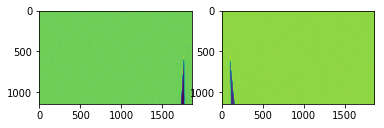

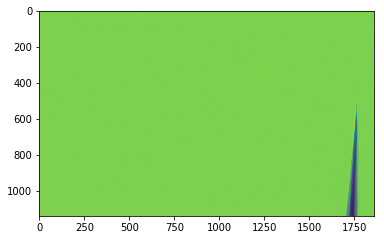

In [22]:
pin0 = imageio.imread('pin_0deg.tif')

pin180 = imageio.imread('pin_180deg.tif')
pin180 = transform_image(pin0[:,::-1], rotation=2)

d = 30
pin0 = pin0[d:-d,d:-d]
pin180 = pin180[d:-d,d:-d]

fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(pin0)
ax1.imshow(pin180)

out = image_corrections('pin_0deg.tif', 'pin_180deg.tif')
print(out)
pin180fixed = transform_image(pin180[:,::-1], rotation=out[0])
plt.figure()
plt.imshow(pin0, alpha=1)
plt.imshow(pin180fixed, alpha=0.5)

DEBUG:find_offsets:Using image center (570v, 930h)


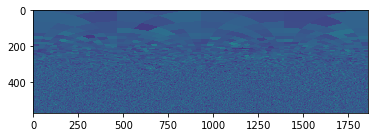

In [34]:
lp_pin0 = logpolar_fancy(pin0, crop=True)
plt.imshow(lp_pin0)


  0%|          | 0/15 [00:00<?, ?it/s]

Real: -1.7497°


100%|██████████| 15/15 [00:19<00:00,  1.31s/it]


Calc: 1.7062°, (15.5, 1.0)


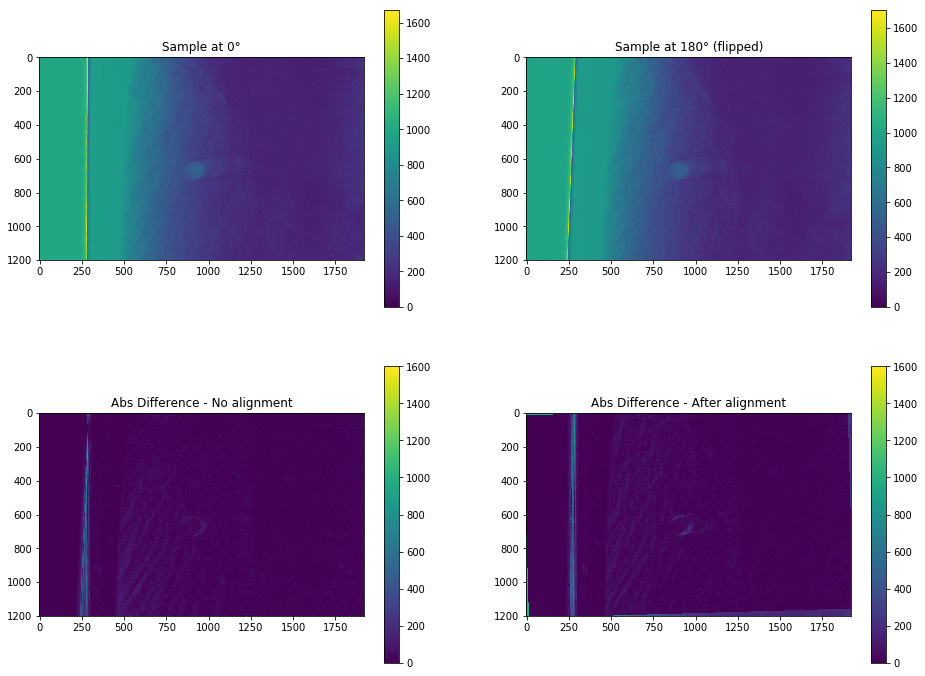

In [38]:
# First get the real answer from ImageJ
diff = np.arctan(1100/41) - np.arctan(1042/7)
print("Real: {:.4f}°".format(np.degrees(diff)))

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

sample0 = imageio.imread('sple_rot_0deg.tif').astype('int16')
sample180 = imageio.imread('sple_rot_180deg.tif').astype('int16')

# Plot the input data
ax0, ax1 = axs[0]
im = ax0.imshow(sample0, vmin=0)
plt.colorbar(im, ax=ax0)
ax0.set_title("Sample at 0°")
im = ax1.imshow(sample180[:,::-1], vmin=0)
plt.colorbar(im, ax=ax1)
ax1.set_title("Sample at 180° (flipped)")

# Do a test alignment
out = image_corrections('sple_rot_0deg.tif', 'sple_rot_180deg.tif')
sample180fixed = transform_image(sample180[:,::-1], rotation=out[0], translation=out[1])
print("Calc: {:.4f}°, {}".format(out[0], out[1]))

# Plot the results of the alignment
ax0, ax1 = axs[1]

# Plot the non-corrected data
im = ax0.imshow(np.abs(sample0 - sample180[:,::-1]), vmin=0, vmax=1600)
plt.colorbar(im, ax=ax0)
# ax0.imshow(sample180[:,::-1], alpha=0.5)
ax0.set_title("Abs Difference - No alignment")

# Plot the corrected data
im = ax1.imshow(np.abs(sample0 - sample180fixed[0]), vmin=0, vmax=1600)
plt.colorbar(im, ax=ax1)
# ax1.imshow(sample180fixed[0], alpha=0.5)
ax1.set_title("Abs Difference - After alignment")

pass

In [35]:
print(sample0.dtype)

uint16


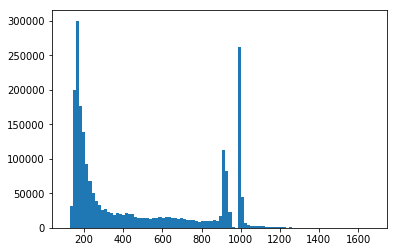

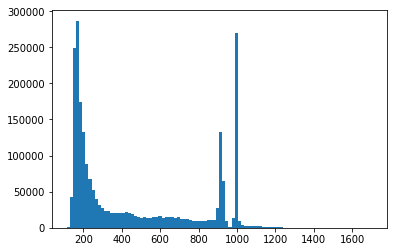

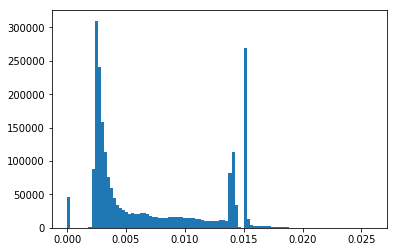

In [21]:
plt.figure()
# plt.imshow(sample0)
# plt.colorbar()
plt.hist(sample0.flatten(), bins=100)


plt.figure()
# plt.imshow(sample180[:,::-1])
# plt.colorbar()
plt.hist(sample180.flatten(), bins=100)


plt.figure()
# plt.imshow(sample180fixed[0])
# plt.colorbar()
plt.hist(sample180fixed[0].flatten(), bins=100)

pass

In [13]:
# Plot the non-corrected data
print(sample180[:,::-1].shape)
ax0.imshow(sample0 - sample180[:,::-1])
# ax0.imshow(sample180[:,::-1], alpha=0.5)
ax0.set_title("No alignment")

# Plot the corrected data
ax1.imshow(sample0)
ax1.imshow(sample180fixed[0], alpha=0.5)
ax1.set_title("After alignment")

(1200, 1920)


Text(0.5,1,'After alignment')

In [ ]:
t = (-out[1][0], -10*out[1][1])
sample180fixed = transform_image(sample180[:,::-1], rotation=out[0], translation=out[1])
print("Calc: {:.4f}°".format(out[0]))

# Plot the results of the alignment
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the non-corrected data
ax0.imshow(sample0)
ax0.imshow(sample180[:,::-1], alpha=0.5)
ax0.set_title("No alignment")

# Plot the corrected data
ax1.imshow(sample0)
ax1.imshow(sample180fixed, alpha=0.5)
ax1.set_title("After alignment")

DEBUG:find_offsets:Using image center (600v, 960h)
DEBUG:find_offsets:Using image center (600v, 960h)


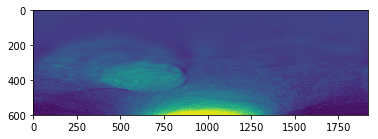

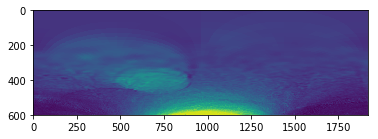

In [35]:
plt.imshow(logpolar_fancy(sample0, crop=True))

plt.figure()
plt.imshow(logpolar_fancy(sample180[:,::-1], crop=True))


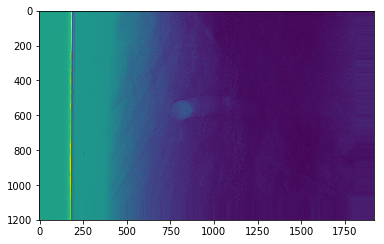

In [7]:
plt.imshow(transform_image(sample0, translation=(100, 100)))